### Setup & Initialization

In [1]:
import os
import sys
import yaml
from contextlib import contextmanager
from datasets import load_dataset
from dotenv import load_dotenv
from tqdm.notebook import tqdm
from openai import APIStatusError, RateLimitError, APIConnectionError
from getpass import getpass
import anthropic
import json
import ast
import re
import numpy as np

In [2]:
SAMPLE_SIZE = 50
REPEAT_ANNOTATION = 1

In [3]:
foundaiton_model = "claude-3-sonnet-20240229"
client = anthropic.Anthropic(
    api_key=getpass("ANTHROPIC API KEY: ")
)

In [4]:
# Specifying path to the necessary files and folders
PATH_TO_SRC = os.path.abspath('../../../')

# Where to get annotation examples for the prompt
ANNOTATION_EXAMPLES_PATH = os.path.join(PATH_TO_SRC, 'src/query/ner_examples_all_languages.json')
CONFIG_PATH = os.path.join(PATH_TO_SRC, "settings/config.yml")
ENV_FILE_PATH = os.path.join(PATH_TO_SRC, '.env')
# Folder to save annotations
RESULTS_PATH = os.path.join(PATH_TO_SRC, 'data/foundation_model_selection/claude3-sonet')

In [5]:
@contextmanager
def extend_sys_path(path):
    if path not in sys.path:
        # Append the path to sys.path
        sys.path.append(path)
    try:
        # Execute code inside the 'with' statement
        yield
    finally:
        # Remove the path from sys.path
        if path in sys.path:
            sys.path.remove(path)

In [6]:
# Temporarily add module_path and import functions
with extend_sys_path(PATH_TO_SRC):
    from src.data.sample import sample_for_model_selection
    from src.query.query_gpt import ask_gpt, add_annotation_examples
    from src.query.prompts import MAIN_PROMPT
    from src.utils.utils import calculate_consistency_score

In [7]:
print(load_dotenv(dotenv_path=ENV_FILE_PATH))

True


In [8]:
# Reading config file
config = yaml.safe_load(open(os.path.join(PATH_TO_SRC, "settings/config.yml")))

# Load indx-to-label_name mapping
label_mapping = config['label_mapping']
label_mapping

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-DATE',
 8: 'I-DATE'}

### Utils

In [10]:
import time
def ask_gpt_short(
        tokens, language, examples, client, user_prompt,
        max_tokens=1000,
        temperature=0.1,
        model=foundaiton_model,
        system_prompt=None):

    sentence = str(tokens)
    ner_tags = None

    if system_prompt is None:
        system_prompt = f"You are a named entity labelling expert in {language} language."

    # Format user prompt
    user_prompt = user_prompt.format(language=language, sentence=sentence, examples=examples)

    # Save query params
    query_params = {
        'model': model,
        'temperature': temperature,
        'system': system_prompt,
        'messages': [
                        {
                            "role": "user", 
                            "content": [
                                {
                                    "type":"text",
                                    "text":user_prompt
                                }
                            ]
                        }
                     ],
        'max_tokens': max_tokens,
    }

    try:
        # Query the model
        time.sleep(12)
        response = client.messages.create(**query_params)
        # Extract model answer
        answer = response.content[0].text
        return answer

    except APIConnectionError as e:
        raise Exception(f"The server could not be reached: {e.__cause__}")
    except RateLimitError as e:
        raise Exception(f"A 429 status code was received: {e}")
    except APIStatusError as e:
        raise Exception(f"Non-200-range status code received: {e.status_code}, {e.response}")

In [11]:
def repeat_annotation(n_repeat=10, **ask_gpt_kwargs):
    # Counters
    no_json_counter = 0  # No json was provided by the model
    incorrect_format_counter = 0  # Number of records parsed in the incorrect format 

    # Results
    ner_tokens_arr = []

    for i in tqdm(range(n_repeat)):
        # Send request to a model
        model_response = ask_gpt_short(**ask_gpt_kwargs)

        if ask_gpt_kwargs['model'] in ['gpt-4-1106-preview', 'gpt-4-0125-preview',"llama2:70b","llama2","mistral:7b",foundaiton_model]:
            # Newer models provide json
            try:
                ner_tags = json.loads(model_response)['output']
                ner_tokens_arr.append(ner_tags)
            except Exception as e:
                print('#'*80)
                print(e)
                print(model_response)
                incorrect_format_counter += 1
                continue
        else:
            # Extract json only
            match = re.search(r'\{(.*?)\}', model_response)
            if match:
                content = match.group(0)
                # Format output string to parse it as JSON
                try:
                    ner_tags = json.loads(json.dumps(ast.literal_eval(content)))['output']
                    ner_tokens_arr.append(ner_tags)
                except Exception as e:
                    print('#'*80)
                    print(e)
                    print(model_response)
                    incorrect_format_counter += 1
                    continue
            else:
                print('#'*80)
                print('No json found in model\'s response:', model_response)
                no_json_counter += 1
                continue
    print(f'Number of model responses without json: {no_json_counter}')
    print(f'Number of model responses with incorrect formatting: {incorrect_format_counter}')
    return ner_tokens_arr

In [12]:
target_languages= ['tsn','zul','bam','bbj','fon']

### Querying all

Language: Tswana


  0%|          | 0/3 [00:00<?, ?it/s]

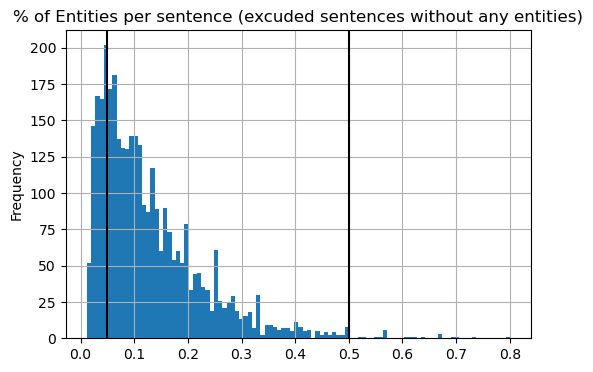

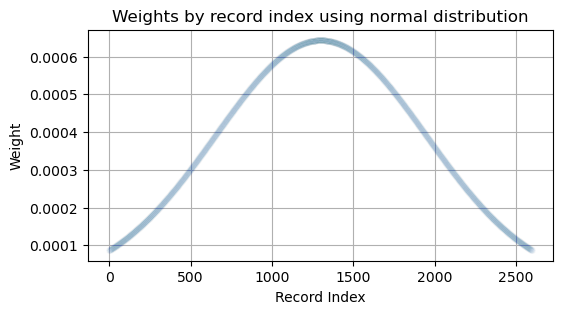

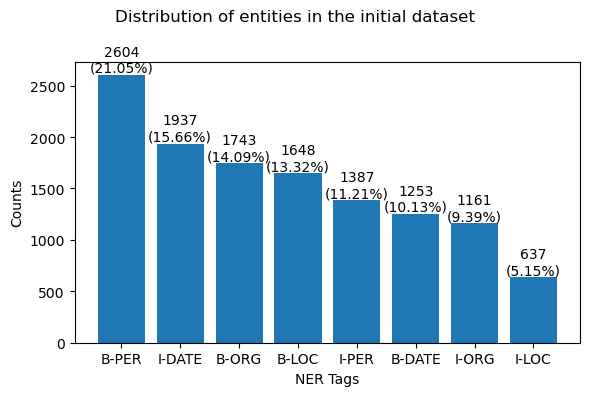

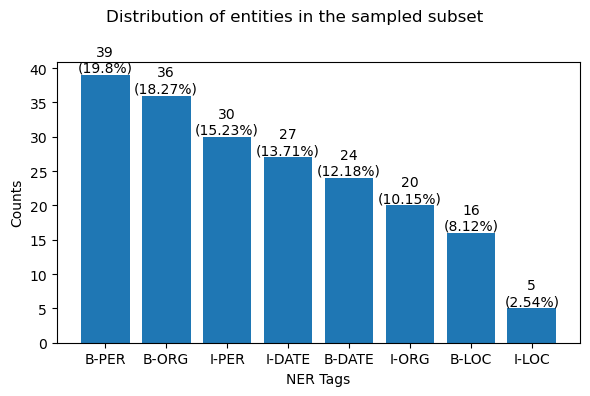

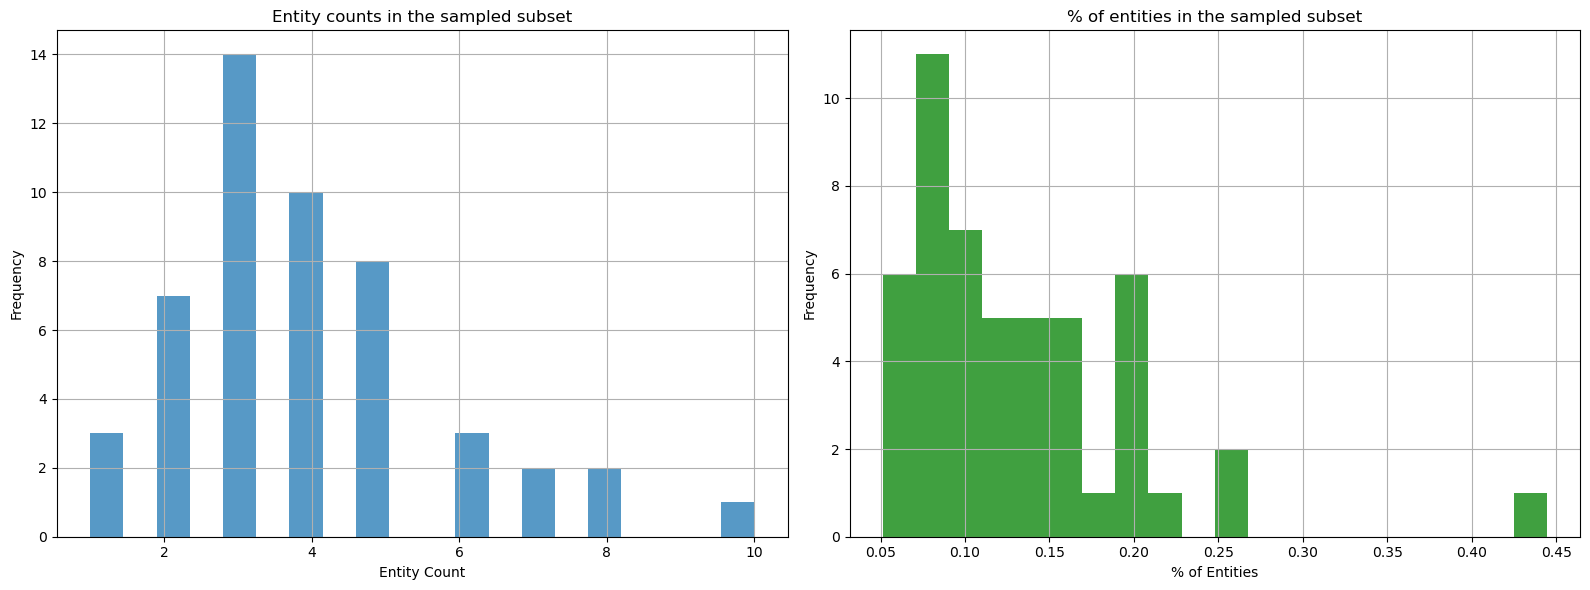


Iteration: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 1


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 2


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 3


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 4


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 5


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 6


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 7


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 8


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 9


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 10


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 11


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 12


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 13


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 14


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 15


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 16


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 17


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 18


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 19


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 20


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 21


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 22


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 23


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 24


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 25


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 26


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 27


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 28


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 29


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 30


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 31


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 32


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 33


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 34


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 35


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 36


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 37


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 38


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 39


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 40


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting ',' delimiter: line 13 column 8 (char 225)
{
  "output": [
    ["Ngaka", "B-PER"],
    [".", "O"],
    ["van", "I-PER"],
    ["Zyl", "I-PER"],
    ["a", "O"],
    ["re", "O"],
    ["setlhopha", "O"],
    ["sa", "O"],
    ["Facebook", "B-ORG"],
    ["sa", "O"],
    ["""""", "O"],
    ["screen", "O"],
    ["-", "O"],
    ["her", "O"],
    ["-", "O"],
    ["save", "O"],
    ["-", "O"],
    ["her", "O"],
    ["""""", "O"],
    ["se", "O"],
    ["teng", "O"],
    ["go", "O"],
    ["ka", "O"],
    ["dirisiwa", "O"],
    ["ke", "O"],
    ["balwetse", "O"],
    ["le", "O"],
    ["ba", "O"],
    ["malapa", "O"],
    ["a", "O"],
    ["bona", "O"],
    [".", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 41


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 42


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 43


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 44


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 45


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 46


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 47


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 48


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 49


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0
Execution time:  906.5667181015015 s
Language: Zulu


  0%|          | 0/3 [00:00<?, ?it/s]

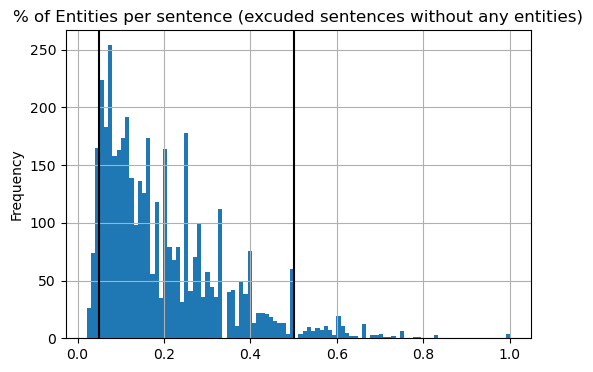

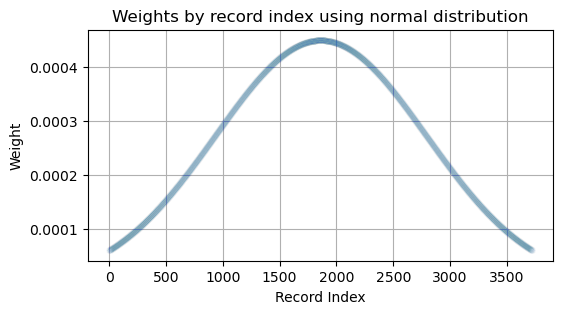

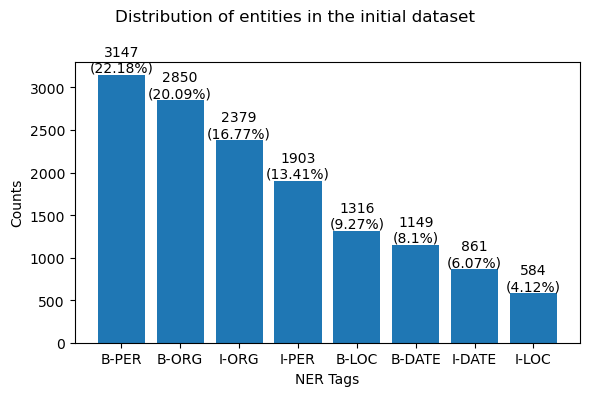

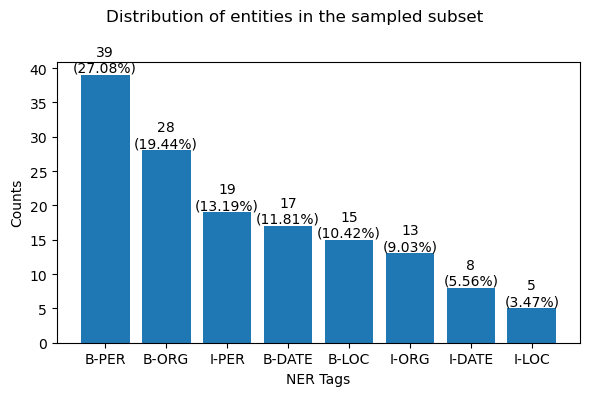

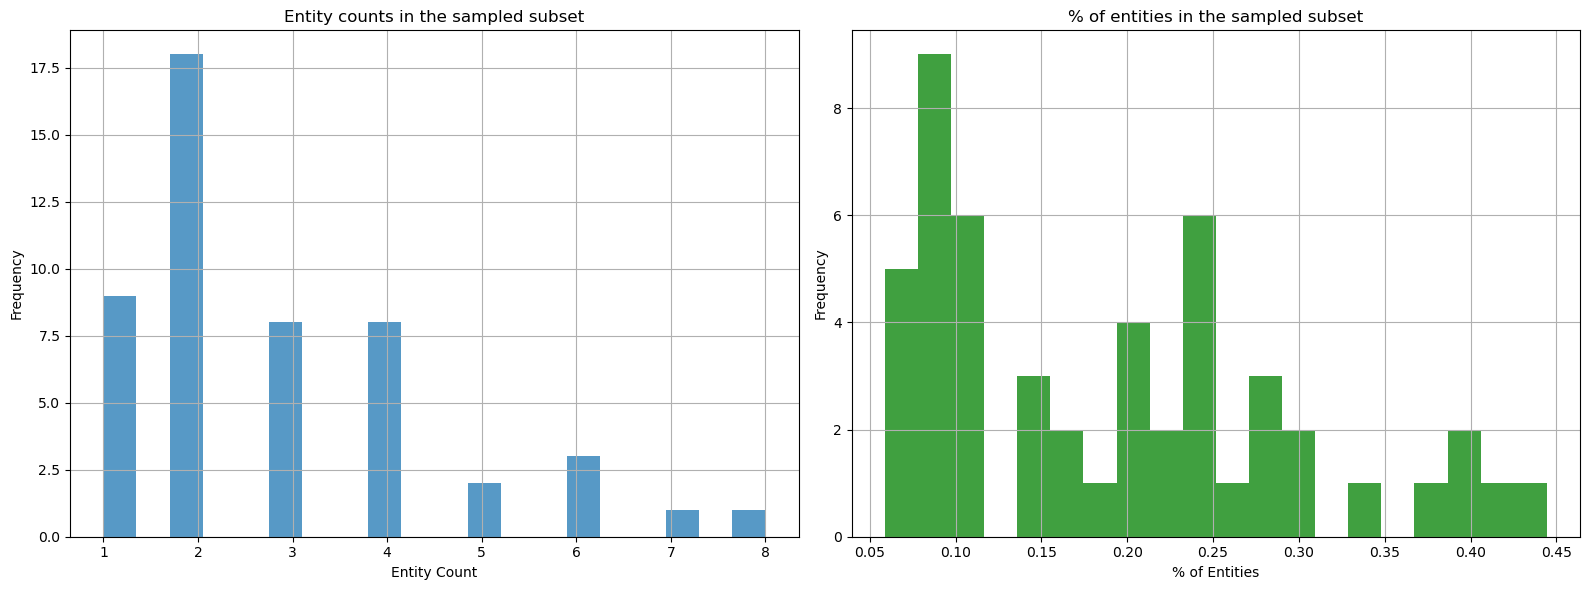


Iteration: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 1


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting value: line 15 column 6 (char 269)
{
  "output": [
    ["Le", "O"],
    ["micimbi", "O"],
    ["ayixwayani", "O"],
    ["uma", "O"],
    ["konke", "O"],
    ["kuzokwenzelwa", "O"],
    ["ekhaya", "O"],
    ["kwenza", "O"],
    ["kube", "O"],
    ["lula", "O"],
    ["kakhulu", "O"],
    [",", "O"],
    ['"', "O"],
    ["kusho", "O"],
    ["uNksz", "B-PER"],
    ["Mnyango", "I-PER"],
    [".", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 2


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 3


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 4


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 5


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting value: line 3 column 6 (char 21)
{
  "output": [
    ['"', "O"],
    ["UMahoota", "B-PER"],
    ["uthe", "O"],
    ["namhlanje", "O"],
    ["kuzoba", "O"],
    ["nenkonzo", "O"],
    ["yesikhumbuzo", "O"],
    ["eBaseline", "B-LOC"],
    [",", "O"],
    ["eNewtown", "B-LOC"],
    ["ngo", "O"],
    ["-", "B-DATE"],
    ["2", "I-DATE"],
    ["emini", "I-DATE"],
    [".", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 6


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 7


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting value: line 3 column 6 (char 21)
{
  "output": [
    ['"', "O"],
    ["Kulo", "B-DATE"],
    ["nyaka", "I-DATE"],
    ["kube", "O"],
    ["nezingqinamba", "O"],
    ["ezilinqandile", "O"],
    ["ibhizinisi", "B-ORG"],
    ["ukuthi", "O"],
    ["likhule", "O"],
    ["liphinde", "O"],
    ["lisabalale", "O"],
    ["ngendlela", "O"],
    ["ebesihlele", "O"],
    ["ngayo", "O"],
    ["njengoba", "O"],
    ["kuphoqeleke", "O"],
    ["ukuthi", "O"],
    ["sishiye", "O"],
    ["indawo", "O"],
    ["obekuzinze", "O"],
    ["kuyo", "O"],
    ["ihhovisi", "O"],
    [",", "O"],
    ["sayosebenzela", "O"],
    ["ekhaya", "O"],
    ["ngenxa", "O"],
    ["yezimo", "O"],
    ["zemali", "O"],
    ["ezisixakazisile", "O"],
    [".", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 8


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 9


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 10


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 11


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting ',' delimiter: line 1 column 130 (char 129)
{"output": [["Sizobophela", "O"], ["abadlali", "O"], ["abangu", "O"], ["-", "O"], ["11", "O"], ["abakhona", "O"], [",", "O"], [""", "O"], ["kusho", "O"], ["uTruter", "B-PER"], [".", "O"]]}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 12


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 13


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 14


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 15


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 16


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 17


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 18


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 19


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 20


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 21


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 22


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 23


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 24


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting ',' delimiter: line 18 column 8 (char 324)
{
  "output": [
    ["Sizimisele", "O"],
    ["ngokuthi", "O"],
    ["siyilwe", "O"],
    ["le", "O"],
    ["mpi", "O"],
    ["uma", "O"],
    ["lo", "O"],
    ["mculi", "O"],
    ["(", "O"],
    ["uGlama", "B-PER"],
    [")", "O"],
    ["engenzi", "O"],
    ["ngendlela", "O"],
    ["efanele", "O"],
    [",", "O"],
    [""", "O"],
    ["kubeka", "O"],
    ["uMeyiwa", "B-PER"],
    [".", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 25


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 26


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 27


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 28


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 29


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting ',' delimiter: line 28 column 8 (char 574)
{
  "output": [
    ["Lasunguleka", "O"],
    ["kanjalo", "O"],
    ["iqembu", "O"],
    ["ngaliqamba", "O"],
    ["ngokuthi", "O"],
    ["Ubuhle", "B-ORG"],
    ["Bemvelo", "I-ORG"],
    [",", "O"],
    ["ngoba", "O"],
    ["uma", "O"],
    ["sihamba", "O"],
    ["sibona", "O"],
    ["ubuhle", "O"],
    ["bemvelo", "O"],
    ["kanti", "O"],
    ["imvelo", "O"],
    ["yiyo", "O"],
    ["eselaphayo", "O"],
    ["ezinkingeni", "O"],
    ["esisuke", "O"],
    ["sinazo", "O"],
    ["ngesikhathi", "O"],
    ["sihamba", "O"],
    ["ezintabeni", "O"],
    [",", "O"],
    [""", "O"],
    ["kusho", "O"],
    ["yena", "O"],
    [".", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 30


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 31


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 32


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 33


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 34


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 35


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 36


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 37


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 38


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 39


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 40


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 41


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 42


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 43


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 44


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 45


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 46


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 47


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 48


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 49


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0
Execution time:  826.6336860656738 s
Language: Bambara


  0%|          | 0/3 [00:00<?, ?it/s]

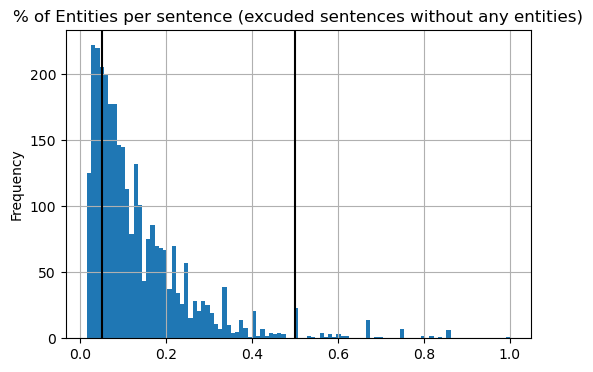

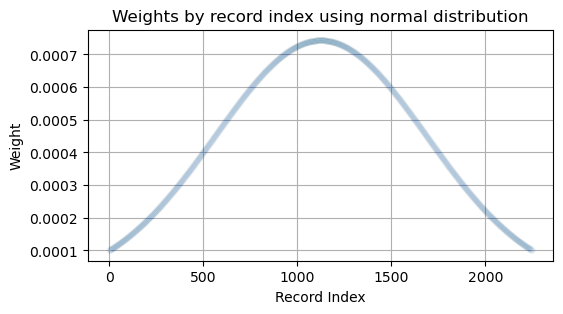

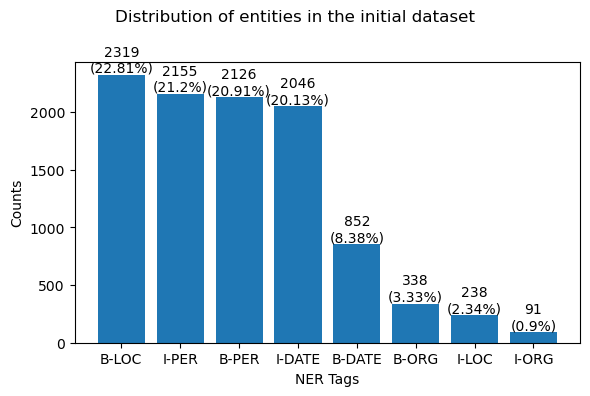

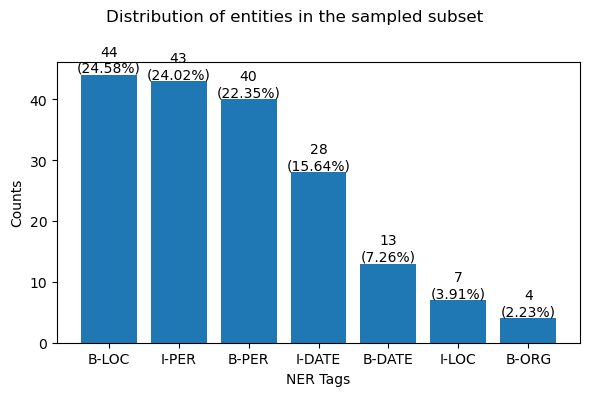

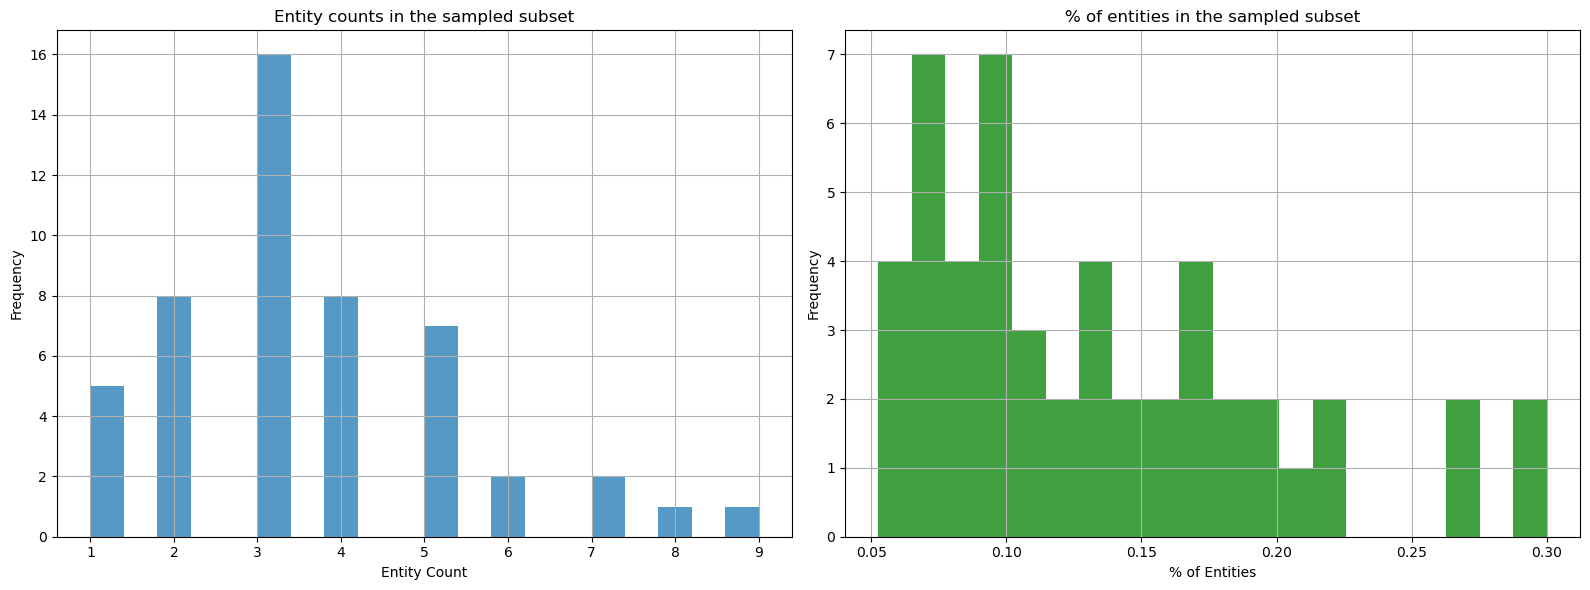


Iteration: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 1


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 2


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 3


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting property name enclosed in double quotes: line 1 column 3 (char 2)
{ 'output': [['A', 'O'], ['ka', 'O'], ['fan', 'O'], ['na', 'O'], [',', 'O'], ['Seku', 'B-PER'], ['Sɛki', 'I-PER'], ['a', 'O'], ['bɛ', 'O'], ['fɔ', 'O'], ['min', 'O'], ['ma', 'O'], ['Bako', 'B-PER'], [',', 'O'], ['SEYƐSI', 'B-ORG'], ['Duguwolofila', 'I-ORG'], ['degelikaramɔgɔ', 'O'], ["bɛn'a", 'O'], ['fɔ', 'O'], ["k'a", 'O'], ['ye', 'O'], ['ɛsitadi', 'O'], ['maliyɛn', 'O'], ['ka', 'O'], ['ntolatantɔn', 'O'], ['ɲumanba', 'O'], ['ye', 'O'], ['.', 'O']] }
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 4


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 5


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 6


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 7


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 8


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 9


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 10


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 11


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 12


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 13


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 14


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 15


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 16


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 17


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 18


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 19


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 20


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 21


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 22


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting ',' delimiter: line 11 column 8 (char 188)
{
  "output": [
    ["rapudɔnkilidala", "O"],
    ["Mamadu", "B-PER"],
    ["Gasama", "I-PER"],
    ["a", "O"],
    ["bɛ", "O"],
    ["fɔ", "O"],
    ["min", "O"],
    ["ma", "O"],
    ["""""", "O"],
    ["Gasipi", "B-ORG"],
    ["""""", "O"],
    ["minɛ", "O"],
    ["ka", "O"],
    ["kasodonsɛbɛn", "O"],
    ["da", "O"],
    ["a", "O"],
    ["kan", "O"],
    [",", "O"],
    ["""""", "O"],
    ["forobabasigi", "O"],
    ["duuruli", "O"],
    ["""""", "O"],
    ["kosɔn", "O"],
    [".", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 23


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 24


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 25


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 26


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 27


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 28


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 29


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 30


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 31


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting ',' delimiter: line 19 column 8 (char 350)
{
  "output": [
    ["U", "O"],
    ["kɛtɔ", "O"],
    ["ka", "O"],
    ["nin", "O"],
    ["damakasisɛbɛn", "O"],
    ["ladon", "O"],
    [",", "O"],
    ["Koman", "B-PER"],
    ["Kulibali", "I-PER"],
    ["ani", "O"],
    ["Kalilu", "B-PER"],
    ["Jara", "I-PER"],
    ["somɔgɔw", "O"],
    ["y'a", "O"],
    ["jate", "O"],
    ["ko", "O"],
    ["""""", "O"],
    ["BEYƐRI", "B-ORG"],
    ["kuntigi", "O"],
    ["ye", "O"],
    ["fanga", "O"],
    ["kɛ", "O"],
    ["ani", "O"],
    ["kojubakɛw", "O"],
    ["kokɛcogow", "O"],
    ["walasa", "O"],
    ["k'u", "O"],
    ["fila", "O"],
    ["bila", "O"],
    ["ka", "O"],
    ["jɔ", "O"],
    ["u", "O"],
    ["jalaki", "O"],
    ["la", "O"],
    ["ani", "O"],
    ["u", "O"],
    ["ni", "O"],
    ["Dawuda", "B-PER"],
    ["Yatara", "I-PER"],
    ["cɛla", "O"],
    ["ko", "O"],
    [".", "O"],
    ["""""", "O"]
 

  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 33


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 34


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 35


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 36


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 37


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 38


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 39


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 40


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 41


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting ',' delimiter: line 14 column 8 (char 231)
{
  "output": [
    ["Wa", "O"],
    ["kokɛbagaba", "O"],
    [",", "O"],
    ["Musa", "B-PER"],
    ["Sisoko", "I-PER"],
    ["n'a", "O"],
    ["bɛ", "O"],
    ["fɔ", "O"],
    ["a", "O"],
    ["ma", "O"],
    ["ko", "O"],
    ["""""", "O"],
    ["Fatocɛ", "B-LOC"],
    [",", "O"],
    ["""""", "O"],
    ["ale", "O"],
    ["min", "O"],
    ["tun", "O"],
    ["y'i", "O"],
    ["dogo", "O"],
    [",", "O"],
    ["o", "O"],
    ["minɛnna", "O"],
    ["tarata", "O"],
    ["don", "O"],
    ["zuwɛnkalo", "B-DATE"],
    ["tile", "I-DATE"],
    ["8na", "I-DATE"],
    ["sɔgɔma", "I-DATE"],
    ["nɛgɛ", "I-DATE"],
    ["ɲɛ", "I-DATE"],
    ["5", "I-DATE"],
    ["waati", "I-DATE"],
    ["la", "O"],
    ["a", "O"],
    ["tericɛ", "O"],
    ["fɛ", "O"],
    ["Kanajigila", "B-LOC"],
    [".", "O"]
  ]
}
Number of model responses without json: 0
Number of model respon

  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 43


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 44


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 45


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 46


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting ',' delimiter: line 7 column 8 (char 106)
{
  "output": [
    ["fasodenya", "O"],
    ["lafasako", "O"],
    ["wɛrɛw", "O"],
    [",", "O"],
    ["""""", "O"],
    ["Ibarahima", "B-PER"],
    ["Agi", "I-PER"],
    ["Nɔki", "I-PER"],
    ["y'o", "O"],
    ["dantigɛ", "O"],
    [".", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 47


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 48


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting ',' delimiter: line 3 column 8 (char 23)
{
  "output": [
    ["""""", "O"],
    ["SEPEYI", "O"],
    [",", "O"],
    ["ko", "O"],
    ["sɛbɛlaman", "O"],
    ["tun", "O"],
    ["tɛ", "O"],
    [",", "O"],
    ["fo", "O"],
    ["cɛ", "O"],
    ["tun", "O"],
    ["ka", "O"],
    ["mabɔ", "O"],
    ["min", "O"],
    ["bɛ", "O"],
    ["degun", "O"],
    ["kɛ", "O"],
    [",", "O"],
    ["faden", "O"],
    ["min", "O"],
    ["bɛ", "O"],
    ["degun", "O"],
    ["kɛ", "O"],
    [",", "O"],
    ["o", "O"],
    ["la", "O"],
    [",", "O"],
    ["u", "O"],
    ["ye", "O"],
    ["ne", "O"],
    ["bila", "O"],
    ["yen", "O"],
    [",", "O"],
    ["""""", "O"],
    ["Loran", "B-PER"],
    ["Bagibo", "I-PER"],
    ["y'o", "O"],
    ["dantigɛ", "O"],
    ["a", "O"],
    ["ka", "O"],
    ["so", "O"],
    [",", "O"],
    ["Mama", "B-LOC"],
    [",", "O"],
    ["a", "O"],
    ["wolodugu", "O"],
    ["la", "O"],

  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0
Execution time:  921.1587059497833 s


In [13]:
for LANGUAGE in target_languages:
    language_name = config['languages_names'][LANGUAGE]
    print("Language:",language_name)
    # Loading dataset from HuggingFace
    data = load_dataset(config['dataset'], LANGUAGE)
    sampled_subset = sample_for_model_selection(data, label_mapping, n_samples=SAMPLE_SIZE, verbose=True)
    sampled_subset
    ask_gpt_params = {
        'language': language_name,
        'examples': add_annotation_examples(ANNOTATION_EXAMPLES_PATH, language_name),
        'client': client,
        'user_prompt': MAIN_PROMPT,
        'model': foundaiton_model ,
        'temperature': 0.1
    }
    gpt_annotations = {}
    consistency_scores = []

    # Measure how much time it takes to get all inferences
    start = time.time()


    for i, record in enumerate(sampled_subset):
        print(f'\nIteration: {i}')
        
        try: 
            # Extract ground truth
            ground_truth_labels = [label_mapping[t] for t in record['ner_tags']]
            
            # Extract tokens from current record
            ask_gpt_params['tokens'] = record['tokens']
            # Query the model
            new_labels_gpt4 = repeat_annotation(n_repeat=REPEAT_ANNOTATION, **ask_gpt_params)
            # Save annotations
            gpt_annotations[f'record_{i}'] = {}
            gpt_annotations[f'record_{i}']['pred'] = new_labels_gpt4
            gpt_annotations[f'record_{i}']['true'] = ground_truth_labels
            gpt_annotations[f'record_{i}']['tokens'] = record['tokens']
            
            # Calculate consistency score
            consistency = calculate_consistency_score(new_labels_gpt4, ground_truth_labels)
            gpt_annotations[f'record_{i}']['consistency'] = consistency
            consistency_scores.append(consistency)
            
        except Exception as e:
            print(e)
            continue

    # Overall consistency is calculated by averaging individual scores
    gpt_annotations['overall_consistency'] = np.mean(consistency_scores)

    end = time.time()
    print('Execution time: ', end - start, 's')
    with open(os.path.join(RESULTS_PATH, f'{LANGUAGE}.json'), 'w') as file:
        json.dump(gpt_annotations, file, indent=4)
